In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
from sklearn.linear_model import LinearRegression

null performances after coercion: 0
after saturation filter 995
after filter num benchmarks 735
after merge with model versions 740
after merge with benchmark dates 740
Original number of rows: 740
Number of rows after aggregation: 658


In [3]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark, anchor_difficulty, anchor_slope)

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 36, initial cost 2.3912e+01, final cost 1.6297e+00, first-order optimality 7.03e-05.


In [4]:
# keep only models released before cutoff
cutoff_date = "2024-07-01"
cutoff_date = pd.to_datetime(cutoff_date)
scores_df['date'] = pd.to_datetime(scores_df['date'], errors='coerce')
scores_df_cut = scores_df[scores_df['date'] < cutoff_date]
scores_df_cut = scores_df_cut[scores_df_cut['benchmark_release_date'] < cutoff_date]
dropped_models = set(scores_df['model']) - set(scores_df_cut['model'].unique())
print(f"Models dropped by date filter: {len(dropped_models)} →", dropped_models)
dropped_benchmarks = set(scores_df['benchmark']) - set(scores_df_cut['benchmark'].unique())
print(f"Benchmarks dropped by date filter: {len(dropped_benchmarks)} →", dropped_benchmarks)

anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df2, df_cm2, df_db2 = fit_statistical_model(scores_df_cut, anchor_benchmark, anchor_difficulty, anchor_slope)

Models dropped by date filter: 67 → {'grok-3-mini-beta_low', 'gemini-2.0-flash-exp', 'qwen2.5-32b-instruct', 'DeepSeek-R1', 'claude-3-7-sonnet-20250219_16K', 'gemini-1.5-pro-002', 'mistral-large-2407', 'Qwen2.5-72B', 'Llama-4-Scout-17B-16E-Instruct', 'gpt-4o-2024-11-20', 'qwen-max-2025-01-25', 'qwen2.5-72b-instruct', 'Llama-3.1-8B-Instruct', 'Llama-4-Maverick-17B-128E-Instruct', 'claude-opus-4-20250514_16K', 'gpt-4.1-nano-2025-04-14', 'gemini-2.5-pro-preview-03-25', 'grok-2-1212', 'o1-mini-2024-09-12_high', 'Llama-3.1-405B-Instruct', 'gpt-4.5-preview-2025-02-27', 'gpt-4.1-2025-04-14', 'mistral-medium-2505', 'gemini-2.5-pro-preview-05-06', 'qwen-plus-2025-01-25', 'o4-mini-2025-04-16_medium', 'o1-preview-2024-09-12', 'gpt-4.1-mini-2025-04-14', 'DeepSeek-R1-0528', 'o1-2024-12-17_high', 'o3-2025-04-16_medium', 'claude-opus-4-20250514', 'o1-2024-12-17_medium', 'gemini-1.5-flash-002', 'o3-mini-2025-01-31_high', 'Llama-3.1-405B', 'grok-3-mini-beta_high', 'gemini-2.5-pro-exp-03-25', 'gemini-2.

In [5]:
for i in [df1, df2, df_cm1, df_cm2, df_db1, df_db2]:
  print(len(i))

658
164
108
40
25
9


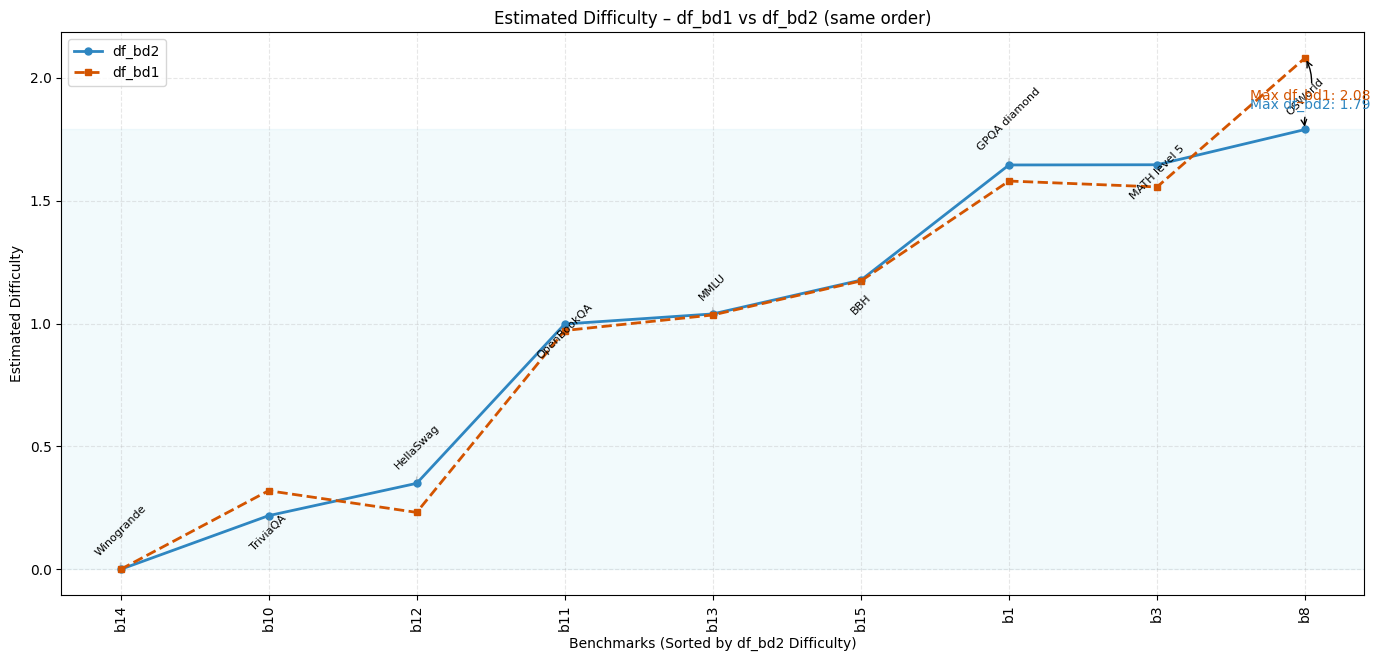

In [6]:
# --- 1. Sort df_db2 exactly as before ----------------------------------------
sorted_df2 = df_db2.sort_values(by="estimated_difficulty").reset_index(drop=True)

# --- 2. Align df_bd1 to that order -------------------------------------------
#   (will silently insert NaN if df_bd1 is missing a benchmark_id)
aligned_df1 = (
    df_db1                      # original
    .set_index("benchmark_id")  # use benchmark_id as index
    .reindex(sorted_df2["benchmark_id"])  # re-order / align
    .reset_index()              # restore column shape
)

# --- 3. Grab the columns you need -------------------------------------------
x              = np.arange(len(sorted_df2))                 # shared x-axis
y2_difficulty  = sorted_df2["estimated_difficulty"].values   # df_bd2 (sorted)
y1_difficulty  = aligned_df1["estimated_difficulty"].values  # df_bd1 (aligned)
bench_ids      = sorted_df2["benchmark_id"].values
bench_names    = sorted_df2["benchmark_name"].values

# --- 4. Plot -----------------------------------------------------------------
plt.figure(figsize=(14, 8))

# df_bd2 (your original line)
plt.plot(
    x, y2_difficulty,
    marker='o', linestyle='-', linewidth=2, markersize=5,
    color='#2E86C1', label='df_bd2'
)

# df_bd1 (second line – tweak style/colour as you like)
plt.plot(
    x, y1_difficulty,
    marker='s', linestyle='--', linewidth=2, markersize=5,
    color='#D35400', label='df_bd1'
)

# --- 5. Cosmetics (labels, grid, ticks, annotations) -------------------------
plt.xlabel('Benchmarks (Sorted by df_bd2 Difficulty)')
plt.ylabel('Estimated Difficulty')
plt.title('Estimated Difficulty – df_bd1 vs df_bd2 (same order)')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, bench_ids, rotation=90)

# (Optional) annotate benchmark names just once to avoid clutter
for i, (diff, name) in enumerate(zip(y2_difficulty, bench_names)):
    y_offset = 10 if i % 2 == 0 else -25
    plt.annotate(
        name,
        xy=(i, diff),
        xytext=(0, y_offset),
        textcoords='offset points',
        ha='center', fontsize=8, rotation=45,
        arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
    )

# Add legend to distinguish the two data sources
plt.legend()

# Light background band (optional)
plt.axhspan(y2_difficulty.min(), y2_difficulty.max(), alpha=0.1, color='skyblue')

# Min/Max annotations for each line (optional but illustrative)
plt.annotate(f'Max df_bd2: {y2_difficulty.max():.2f}',
             xy=(x[y2_difficulty.argmax()], y2_difficulty.max()),
             xytext=(-40, 15), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
             color='#2E86C1')

plt.annotate(f'Max df_bd1: {np.nanmax(y1_difficulty):.2f}',
             xy=(x[np.nanargmax(y1_difficulty)], np.nanmax(y1_difficulty)),
             xytext=(-40, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
             color='#D35400')

# Make room for rotated x-labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

plt.show()


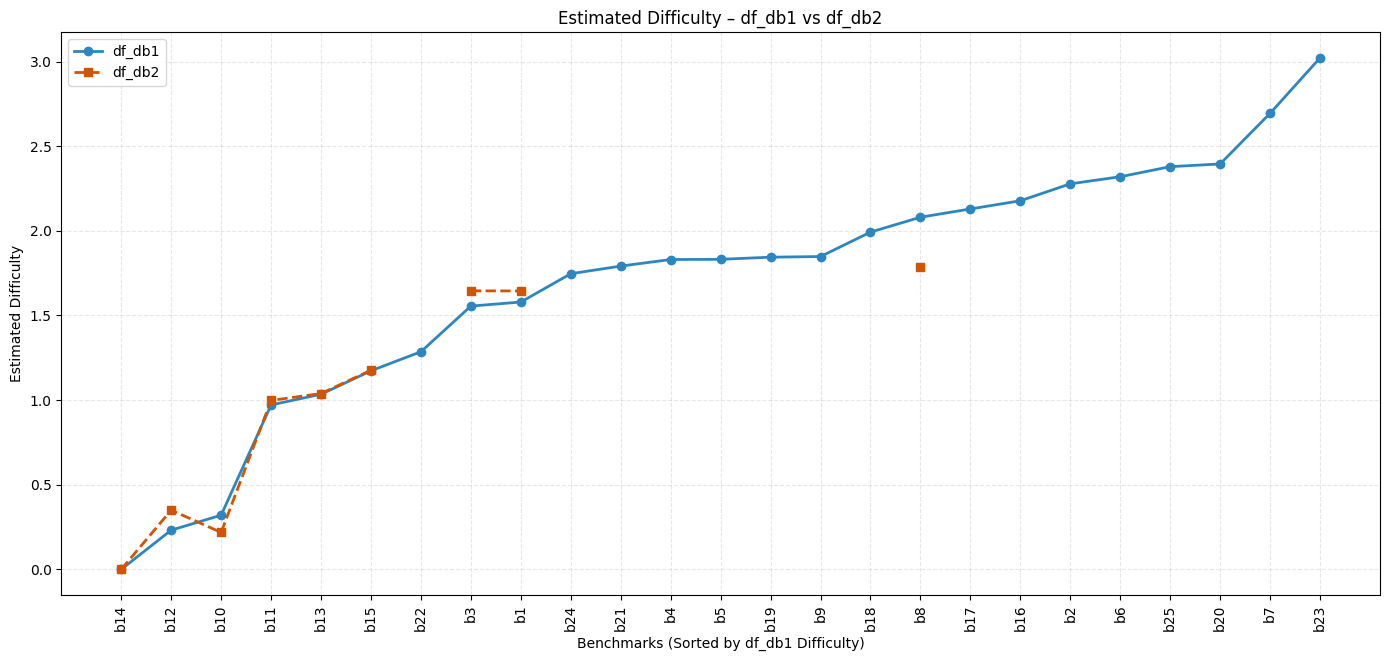

In [7]:
# ──────────────────────────────────────────────────────────────
# 1. Sort df_db1 by difficulty (defines x-axis order)
# ──────────────────────────────────────────────────────────────
sorted_df1 = (
    df_db1
    .sort_values(by="estimated_difficulty")
    .reset_index(drop=True)
)

# ──────────────────────────────────────────────────────────────
# 2. (Optional) deduplicate df_db2 on benchmark_id
#     – keeps the HIGHEST difficulty row per benchmark_id
#       (swap for mean/median if you prefer)
# ──────────────────────────────────────────────────────────────
df_db2_dedup = (
    df_db2
    .sort_values("estimated_difficulty", ascending=False)  # largest first
    .drop_duplicates(subset="benchmark_id", keep="first")
)

# ──────────────────────────────────────────────────────────────
# 3. Align df_db2 to df_db1 order
#    Any benchmark missing in df_db2 becomes NaN
# ──────────────────────────────────────────────────────────────
aligned_df2 = (
    df_db2_dedup
    .set_index("benchmark_id")
    .reindex(sorted_df1["benchmark_id"])   # align to df_db1
    .reset_index()
)

# ──────────────────────────────────────────────────────────────
# 4. Prepare data for plotting
# ──────────────────────────────────────────────────────────────
x  = np.arange(len(sorted_df1))                       # shared x-coords
y1 = sorted_df1["estimated_difficulty"].values        # df_db1 values
y2 = aligned_df2["estimated_difficulty"].values       # df_db2 values (aligned)

bench_ids   = sorted_df1["benchmark_id"].values
bench_names = sorted_df1["benchmark_name"].values     # if you want labels

# ──────────────────────────────────────────────────────────────
# 5. Plot
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 8))

plt.plot(x, y1, marker='o', linestyle='-', linewidth=2, markersize=6,
         color='#2E86C1', label='df_db1')
plt.plot(x, y2, marker='s', linestyle='--', linewidth=2, markersize=6,
         color='#D35400', label='df_db2')

plt.xlabel('Benchmarks (Sorted by df_db1 Difficulty)')
plt.ylabel('Estimated Difficulty')
plt.title('Estimated Difficulty – df_db1 vs df_db2')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, bench_ids, rotation=90)
plt.legend()

# # Optional annotation block (commented-out to keep the plot clean)
# for i, (diff, name) in enumerate(zip(y1, bench_names)):
#     y_offset = 10 if i % 2 == 0 else -25
#     plt.annotate(
#         name,
#         xy=(i, diff),
#         xytext=(0, y_offset),
#         textcoords='offset points',
#         ha='center', fontsize=8, rotation=45,
#         arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
#     )

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # room for rotated labels
plt.show()


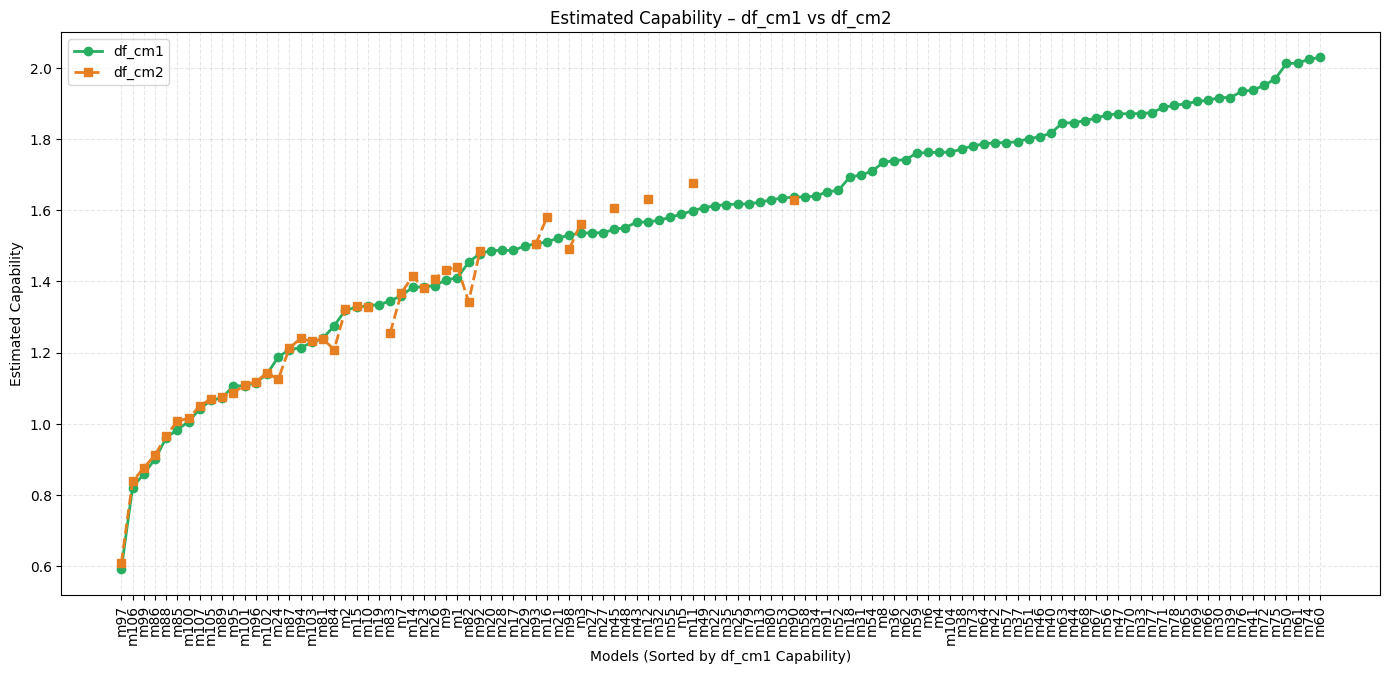

In [8]:
# ──────────────────────────────────────────────────────────────
# 1. Sort df_cm1 by capability (this defines the x-axis order)
# ──────────────────────────────────────────────────────────────
sorted_df1 = (
    df_cm1
    .sort_values(by="estimated_capability")
    .reset_index(drop=True)
)

# ──────────────────────────────────────────────────────────────
# 2. Remove duplicate model_id rows in df_cm2
#    (keep the row with the highest capability for each model_id)
#    ──> swap this block out if you prefer a mean/median instead
# ──────────────────────────────────────────────────────────────
df_cm2_dedup = (
    df_cm2
    .sort_values("estimated_capability", ascending=False)  # biggest first
    .drop_duplicates(subset="model_id", keep="first")      # keep that row
)

# Optional sanity check – uncomment to see what was removed:
# dupes = df_cm2[df_cm2.duplicated('model_id', keep=False)]
# print(f"Found {len(dupes)} duplicate rows in df_cm2"); dupes.head()

# ──────────────────────────────────────────────────────────────
# 3. Align df_cm2 (deduped) to the df_cm1 order
#    Any model_id missing from df_cm2 becomes NaN (gap in the line)
# ──────────────────────────────────────────────────────────────
aligned_df2 = (
    df_cm2_dedup
    .set_index("model_id")
    .reindex(sorted_df1["model_id"])   # align to df_cm1 order
    .reset_index()
)

# ──────────────────────────────────────────────────────────────
# 4. Prepare data for plotting
# ──────────────────────────────────────────────────────────────
x  = np.arange(len(sorted_df1))                      # shared x-coords
y1 = sorted_df1["estimated_capability"].values       # df_cm1 values
y2 = aligned_df2["estimated_capability"].values      # df_cm2 values (aligned)

model_ids   = sorted_df1["model_id"].values
model_names = sorted_df1["model"].values

# ──────────────────────────────────────────────────────────────
# 5. Plot
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 8))

plt.plot(x, y1, marker='o', linestyle='-', linewidth=2, markersize=6,
         color='#27AE60', label='df_cm1')
plt.plot(x, y2, marker='s', linestyle='--', linewidth=2, markersize=6,
         color='#E67E22', label='df_cm2')

plt.xlabel('Models (Sorted by df_cm1 Capability)')
plt.ylabel('Estimated Capability')
plt.title('Estimated Capability – df_cm1 vs df_cm2')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, model_ids, rotation=90)
plt.legend()

# #   Annotate each point once (using df_cm1) to avoid clutter
# for i, (cap, name) in enumerate(zip(y1, model_names)):
#     y_offset = 10 if i % 2 == 0 else -25
#     plt.annotate(
#         name,
#         xy=(i, cap),
#         xytext=(0, y_offset),
#         textcoords='offset points',
#         ha='center', fontsize=8, rotation=45,
#         arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
#     )

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # room for rotated x-labels
plt.show()


Slope   : 0.3433 capability units / year
Intercept: -17.2335


/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_1952/1647213025.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx  = pd.date_range(start=last_date, end=forecast_to, freq="M")


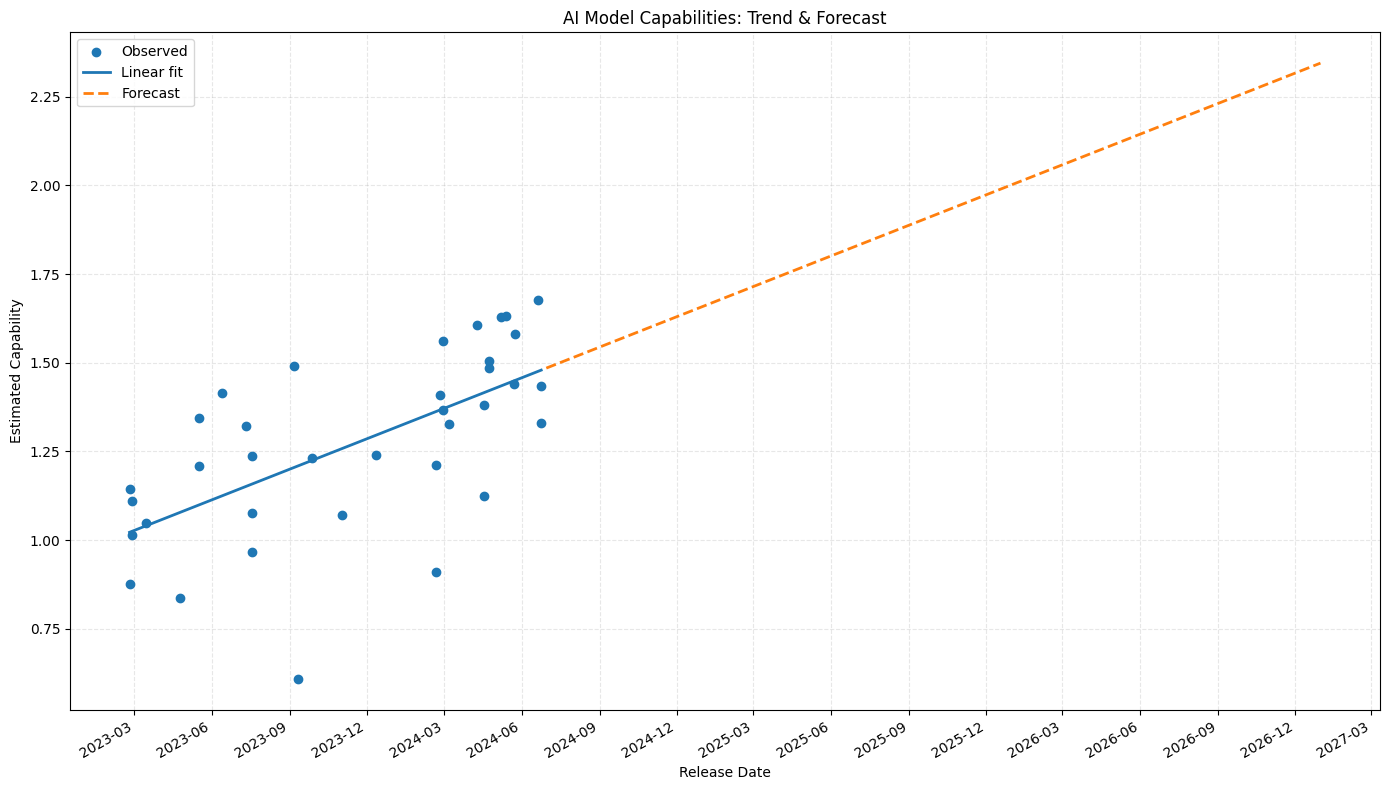

Predicted capability on 2025-12-01: 1.973


In [9]:
# 1️⃣  Prepare the data ------------------------------------------------------
# `dates_num` is already numeric (days since 0001-01-01 from mdates.date2num)
# ----------------------------------------
# 0️⃣  Pick a cutoff year
cutoff_date  = pd.Timestamp(f"2023-01-01")

# 1️⃣  Convert / sort (unchanged from before)
df_cm2['date_obj'] = pd.to_datetime(df_cm2['date'])
sorted_df = df_cm2.sort_values(by="date_obj").reset_index(drop=True)

# 2️⃣  Keep only rows on/after the cutoff
mask        = sorted_df['date_obj'] >= cutoff_date
fit_df      = sorted_df.loc[mask]

# 3️⃣  Pull the columns you need for plotting / modelling
model_names = fit_df["model"]
dates       = fit_df["date_obj"]
capabilities= fit_df["estimated_capability"]

# 4️⃣  Convert dates to numbers for matplotlib / sklearn
dates_num   = mdates.date2num(dates)

X = dates_num.reshape(-1, 1)          # shape (n_samples, 1)
y = capabilities.values.astype(float) # ensure numeric

# 2️⃣  Fit the model ---------------------------------------------------------
lin_reg = LinearRegression()
lin_reg.fit(X, y)

print(f"Slope   : {lin_reg.coef_[0]*365:.4f} capability units / year")
print(f"Intercept: {lin_reg.intercept_:.4f}")

# 3️⃣  Create a future timeline ---------------------------------------------
last_date   = dates.max()
forecast_to = pd.Timestamp("2026-12-31")            # ⬅ change horizon here
future_idx  = pd.date_range(start=last_date, end=forecast_to, freq="M")
future_num  = mdates.date2num(future_idx).reshape(-1, 1)

# 4️⃣  Predict capability for the future dates ------------------------------
future_cap  = lin_reg.predict(future_num)

# 5️⃣  Plot the historical data + trend line + forecast ---------------------
plt.figure(figsize=(14, 8))

# Historical scatter
plt.scatter(dates_num, y, label="Observed", zorder=3)

# Fitted line over the observed date range
dates_dense = np.linspace(dates_num.min(), dates_num.max(), 200).reshape(-1, 1)
plt.plot(dates_dense, lin_reg.predict(dates_dense),
         label="Linear fit", linewidth=2)

# Forecast curve
plt.plot(future_num, future_cap, '--', label="Forecast", linewidth=2)

# Formatting (same as before)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xlabel('Release Date')
plt.ylabel('Estimated Capability')
plt.title('AI Model Capabilities: Trend & Forecast')
plt.grid(True, alpha=0.3, linestyle='--')
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

# 6️⃣  Quick lookup: predicted capability at a specific future date ----------
target = pd.Timestamp("2025-12-01")
pred   = lin_reg.predict([[mdates.date2num(target)]])[0]
print(f"Predicted capability on {target.date()}: {pred:.3f}")


                             OLS Regression Results                             
Dep. Variable:     estimated_capability   R-squared:                       0.392
Model:                              OLS   Adj. R-squared:                  0.374
Method:                   Least Squares   F-statistic:                     21.95
Date:                  Tue, 22 Jul 2025   Prob (F-statistic):           4.38e-05
Time:                          23:14:24   Log-Likelihood:                 7.6429
No. Observations:                    36   AIC:                            -11.29
Df Residuals:                        34   BIC:                            -8.119
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.2335      3.950

/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_1952/88618448.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  timeline    = pd.date_range(dates.min(), forecast_to, freq='M')


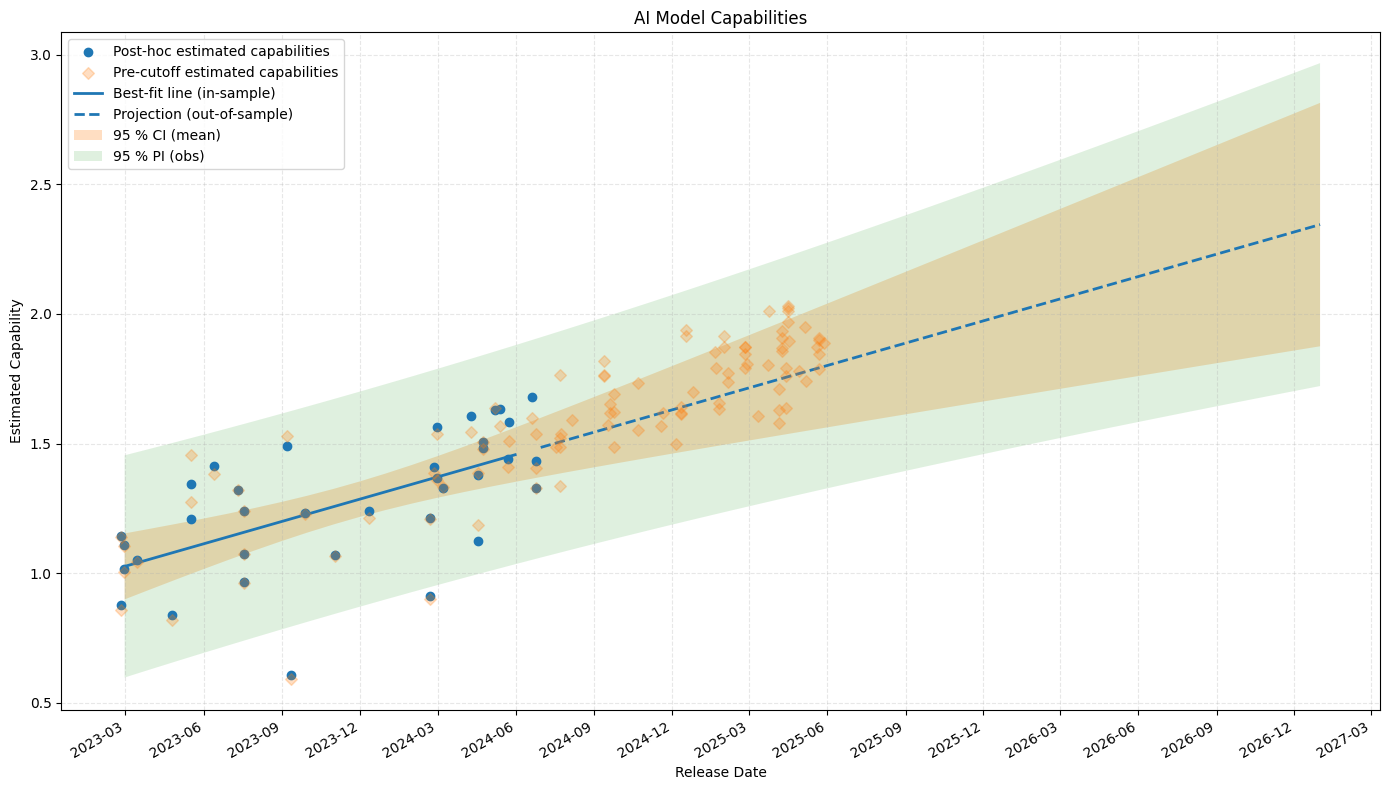

In [12]:
# ------------------------------------------------------------
# 📦  Imports (add statsmodels)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
import statsmodels.api as sm

# ------------------------------------------------------------
# 0️⃣  --------------  YEAR CUTOFF  ---------------------------
cutoff_date  = pd.Timestamp(f"2023-01-01")

# 1️⃣  Prep dataframe (same as before) -----------------------
df_cm2['date_obj'] = pd.to_datetime(df_cm2['date'])
sorted_df          = df_cm2.sort_values('date_obj').reset_index(drop=True)
fit_df             = sorted_df.loc[sorted_df['date_obj'] >= cutoff_date]

dates              = fit_df['date_obj']
caps               = fit_df['estimated_capability'].astype(float)

# 2️⃣  Fit OLS line with statsmodels -------------------------
x_num  = mdates.date2num(dates)
X      = sm.add_constant(x_num)           # adds intercept term
model  = sm.OLS(caps, X).fit()

print(model.summary())                    # optional stat dump

# 3️⃣  Build combined timeline (past + forecast) -------------
forecast_to = pd.Timestamp("2026-12-31")
timeline    = pd.date_range(dates.min(), forecast_to, freq='M')
timeline_num= mdates.date2num(timeline)
X_tl        = sm.add_constant(timeline_num)

pred        = model.get_prediction(X_tl)
pred_df     = pred.summary_frame(alpha=0.05)   # 95 % CI / PI

# ------------------------------------------------------------
# 3️⃣b  Work out where ‘history’ ends and ‘projection’ begins
last_obs_date = dates.max()                     # final df_cm2 point
past_mask     = timeline <= last_obs_date       # True up to (and incl.) last obs
future_mask   = timeline >  last_obs_date       # True after last obs

# convert to num once so we can reuse it
timeline_num  = mdates.date2num(timeline)


# # 4️⃣  Draw a few synthetic future points --------------------
# rng            = np.random.default_rng(0)
# n_sims         = 30
# future_mask    = timeline > dates.max()
# future_mean    = pred_df['mean'][future_mask]
# future_sd      = np.sqrt(model.mse_resid)      # residual std-dev
# future_samples = rng.normal(loc=future_mean,
#                              scale=future_sd,
#                              size=n_sims)

# sample_dates   = rng.choice(timeline[future_mask], size=n_sims, replace=True)
# sample_dates_n = mdates.date2num(sample_dates)

# 4️⃣  Overlay observed capabilities from df_cm1 -------------
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

# apply the SAME cutoff used for df_cm2
df1_fit      = df_cm1.loc[df_cm1['date_obj'] >= cutoff_date]

df1_dates    = df1_fit['date_obj']
df1_caps     = df1_fit['estimated_capability'].astype(float)
df1_dates_num= mdates.date2num(df1_dates)

# 5️⃣  Plot ---------------------------------------------------
plt.figure(figsize=(14, 8))

# -- observed points ------------------------------------------------
plt.scatter(x_num, caps, label='Post-hoc estimated capabilities', zorder=3)

plt.scatter(df1_dates_num, df1_caps, marker='D', color='tab:orange',
            label='Pre-cutoff estimated capabilities', alpha=0.25, zorder=3)

# -- fitted line: SOLID up to last df_cm2 date -----------------------
plt.plot(timeline_num[past_mask],
         pred_df['mean'][past_mask],
         lw=2, label='Best-fit line (in-sample)')

# -- projection: DOTTED after last df_cm2 date ----------------------
plt.plot(timeline_num[future_mask],
         pred_df['mean'][future_mask],
         lw=2, ls='--', color='C0',      # same colour, but dotted (‘--’)
         label='Projection (out-of-sample)')

# -- uncertainty bands (unchanged) ----------------------------------
plt.fill_between(timeline_num,
                 pred_df['mean_ci_lower'], pred_df['mean_ci_upper'],
                 alpha=0.25, label='95 % CI (mean)')
plt.fill_between(timeline_num,
                 pred_df['obs_ci_lower'],  pred_df['obs_ci_upper'],
                 alpha=0.15, label='95 % PI (obs)')

# cosmetics (unchanged) ---------------------------------------------
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()
plt.xlabel('Release Date')
plt.ylabel('Estimated Capability')
plt.title('AI Model Capabilities')
plt.grid(alpha=0.3, ls='--')
plt.legend()
plt.tight_layout()

plt.savefig("capabilities_forecast.pdf")

plt.show()
